In [3]:
# Before running this file, activate the venv using "sklearn-venv\Scripts\activate"

from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import datasets


#for MV
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import datasets
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import validation_curve
plt.style.use('ggplot')

# Using panda.io to read the dataset
unprocessed_data_X = pd.read_csv("heart.csv")
unprocessed_data_y = unprocessed_data_X.loc[:, "target"]

# Feature Selection using a chi-squared scoring function
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html
feature_selection = SelectKBest(chi2, k=11)
processed_data_X = feature_selection.fit_transform(
    unprocessed_data_X, unprocessed_data_y)
processed_data_Y = processed_data_X[:, 10]
# Hyperparameters: score_func - chi2

# These features had the 3 lowest chi2 scores and will be excluded:
# fasting blood sugar > 120 mg/dl
# resting electrocardiographic results (values 0,1,2)
# number of major vessels (0-3) colored by flourosopy

# SMOTE
# https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
smote_processed_data_X, smote_processed_data_Y = SMOTE(
).fit_resample(processed_data_X, processed_data_Y)
# Hyperparameters: sampling_strategy - auto = resampling only the minority class
# k_neighbors - default = 5

# 27 new entries were created by SMOTE to oversample the minority

# 70%/30% Training Test Split
processed_train_X, processed_test_X, processed_train_Y, processed_test_Y = train_test_split(
    processed_data_X, processed_data_Y, test_size=0.3)
smote_train_X, smote_test_X, smote_train_Y, smote_test_Y = train_test_split(
    smote_processed_data_X, smote_processed_data_Y, test_size=0.3)
# Hyperparameters: test_size - 30
# train_size - 70
# shuffle default = True


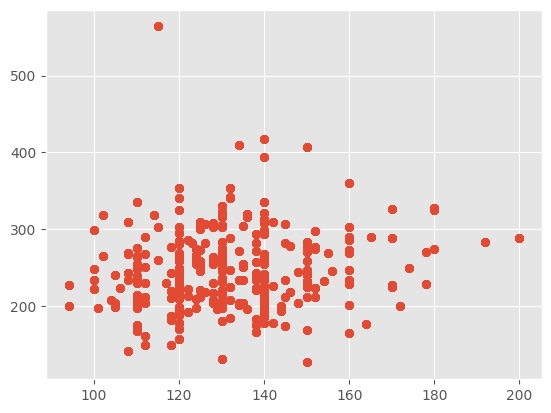

In [4]:
# print(unprocessed_data_X)
g1 = unprocessed_data_X.loc[:, "age":"target"]
plt.scatter('trestbps', 'chol', data=g1);

             0         1         2           3           4           5   \
1025  60.000000  1.000000  0.000000  125.000000  258.000000  141.000000   
1026  61.335333  0.554889  0.000000  127.329333  201.994000  133.780444   
1027  55.000000  0.000000  0.000000  128.000000  205.000000  130.000000   
1028  51.000000  1.000000  0.000000  140.000000  298.000000  122.000000   
1029  57.166004  1.000000  0.944665  124.055335  260.833996  141.000000   
1030  67.000000  1.000000  0.000000  160.000000  286.000000  108.000000   
1031  44.000000  1.000000  0.000000  120.000000  169.000000  144.000000   
1032  52.000000  1.000000  0.000000  112.000000  230.000000  160.000000   
1033  62.000000  0.000000  0.000000  140.000000  268.000000  160.000000   
1034  56.000000  1.000000  2.000000  130.000000  256.000000  142.000000   
1035  58.179442  1.000000  0.358884  127.641116  216.358884  131.538326   
1036  65.960064  1.000000  1.653355  151.306709  210.440095  151.906550   
1037  49.000000  1.000000

c:\Users\Paul Andre Feliciano\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


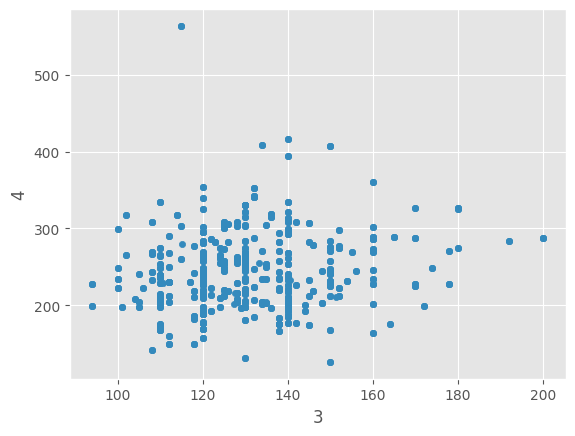

In [5]:
smoteDF = pd.DataFrame(smote_processed_data_X) # Convert SMOTE-treated data numpy array to DataFrame to use .loc
smoteDF.to_csv("SMOTEData.csv")

# print(smoteDF)
g2 = smoteDF.loc[1025:1051,:] # New data from SMOTE
# print (g2) 
smoteDF.plot(x=3, y=4, kind='scatter');

---RANDOM FOREST---
RF w/ SMOTE Test Set Accuracy: 1.0
RF w/ SMOTE Training Set Accuracy: 1.0
RF w/o SMOTE Test Set Accuracy: 1.0
RF w/o SMOTE Training Set Accuracy: 1.0



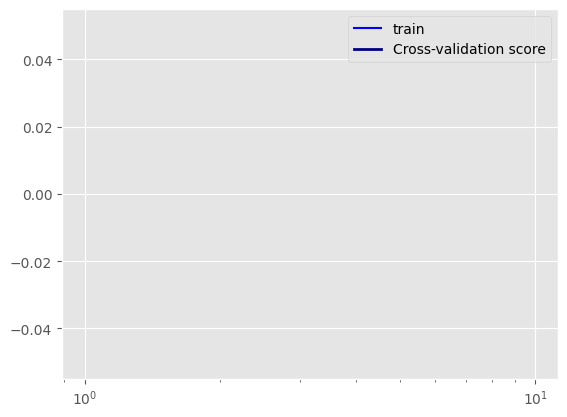

In [6]:
# TODO: RF
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

# TODO: Adjust RF Hyperparameters to avoid overfitting
# Random Forest Hyperparameter grids
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# Refer to Random Forest documentation for possible parameter values
# n_estimators = [100]
# criterion = ["gini", "entropy", "log_loss"]
# # None or int
# max_depth = [None]
# min_samples_split = [2]
# min_samples_leaf = [1]
# min_weight_fraction_leaf = [0.0]
# max_features = ["sqrt", "log2", None]
# # None or int
# max_leaf_nodes = [None]
# min_impurity_decrease = [0.0]
# bootstrap = [True, False]

# random_forest_parameters = {
#     'n_estimators': n_estimators,
#     'criterion': criterion,
#     'max_depth': max_depth,
#     'min_samples_split': min_samples_split,
#     'min_samples_leaf': min_samples_leaf,
#     'min_weight_fraction_leaf': min_weight_fraction_leaf,
#     'max_features': max_features,
#     'max_leaf_nodes': max_leaf_nodes,
#     'min_impurity_decrease': min_impurity_decrease,
#     'bootstrap': bootstrap,
# }

rf = RandomForestClassifier(random_state = 1, n_estimators = 10)
model_params = {
    'n_estimators': [100],
    'max_features': ['sqrt'],
    'bootstrap': [True],
    'min_samples_leaf': [1],
    'min_samples_split': [2],
    'max_depth': [2]}

# clf = GridSearchCV(rf, model_params, cv=5)
# model = clf.fit(smote_train_X, smote_train_Y)
# print(clf.best_params_)
# print('/n')
# clf.best_params_

# # Exhaustive Grid Search with Cross Validation for Optimal Hyperparameters
# random_forest_searched = GridSearchCV(
#     estimator=random_forest, param_grid=random_forest_parameters, verbose=1)

# # RF w/ SMOTE
# random_forest_smote = random_forest.fit(
#     smote_train_X, smote_train_Y)
# random_forest_smote_test = random_forest.fit(smote_test_X, smote_test_Y)
# print('Random Forest w/ SMOTE Test Set Accuracy: ', end="")
# print(random_forest_smote.score(smote_test_X, smote_test_Y))
# print('Random Forest w/ SMOTE Training Set Accuracy: ', end="")
# print(random_forest_smote.score(smote_train_X, smote_train_Y))
rf.fit(smote_train_X, smote_train_Y)
print('---RANDOM FOREST---')
print('RF w/ SMOTE Test Set Accuracy: ', end="")
print(rf.score(smote_test_X, smote_test_Y))
print('RF w/ SMOTE Training Set Accuracy: ', end="")
print(rf.score(smote_train_X, smote_train_Y))
# # RF w/o SMOTE
# random_forest_processed = random_forest.fit(
#     processed_train_X, processed_train_Y)
# random_forest_processed_test = random_forest.fit(processed_test_X, processed_test_Y)
# print('Random Forest w/o SMOTE Test Set Accuracy: ', end="")
# print(random_forest_processed.score(processed_test_X, processed_test_Y))
# print('Random Forest w/o SMOTE Training Set Accuracy: ', end="")
# print(random_forest_processed.score(processed_train_X, processed_train_Y))
# print()
rf.fit(processed_data_X, processed_data_Y)
print('RF w/o SMOTE Test Set Accuracy: ', end="")
print(rf.score(processed_test_X, processed_test_Y))
print('RF w/o SMOTE Training Set Accuracy: ', end="")
print(rf.score(processed_train_X, processed_train_Y))
print()

param_range = np.logspace(-6, -1, 5)
train_scores, test_scores = validation_curve(
    RandomForestClassifier(),
    smote_train_X,
    smote_train_Y,
    param_name="n_estimators",
    param_range=param_range,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

lw = 2
plt.plot(param_range, train_scores_mean,label="train", color="blue")
plt.semilogx(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

# SVM
print('\n')

---SUPPORT VECTOR MACHINE---
SVM w/ SMOTE Test Set Accuracy: 0.9683544303797469
SVM w/ SMOTE Training Set Accuracy: 1.0
SVM w/o SMOTE Test Set Accuracy: 1.0
SVM w/o SMOTE Training Set Accuracy: 1.0



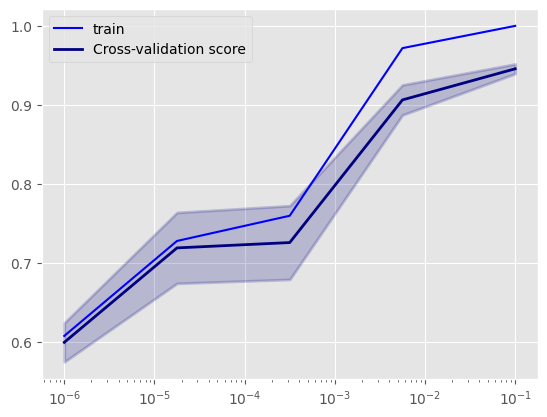

In [7]:
#TODO: SVM
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

# TODO: Adjust SVM Hyperparameters
# SVM Hyperparameter grids
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# Refer to SVM documentation for possible parameter values

C = [1.0]
kernel = ["linear", "poly", "rbf", "sigmoid"]
degree = [3]
# "scale", "auto" or float
gamma = ["scale", "auto"]
coef0 = [0.0]
shrinking = [True, False]
probability = [True, False]
tol = [1e-3]
class_weight = [None, "balanced"]

svm_parameters = {
    'C': C,
    'kernel': kernel,
    'degree': degree,
    'gamma': gamma,
    'coef0': coef0,
    'shrinking': shrinking,
    'probability': probability,
    'tol': tol,
    'class_weight': class_weight
}

# svc = SVC(probability=True)

# # Exhaustive Grid Search with Cross Validation for Optimal Hyperparameters
# svc_searched = GridSearchCV(
#     estimator=svc, param_grid=svm_parameters, verbose=1)
svm = SVC(kernel='rbf', gamma=1)

# SVM w/ SMOTE
svm.fit(smote_train_X, smote_train_Y)
print('---SUPPORT VECTOR MACHINE---')
print('SVM w/ SMOTE Test Set Accuracy: ', end="")
print(svm.score(smote_test_X, smote_test_Y))
print('SVM w/ SMOTE Training Set Accuracy: ', end="")
print(svm.score(smote_train_X, smote_train_Y))

# SVM w/o SMOTE
svm.fit(processed_data_X, processed_data_Y)
print('SVM w/o SMOTE Test Set Accuracy: ', end="")
print(svm.score(processed_test_X, processed_test_Y))
print('SVM w/o SMOTE Training Set Accuracy: ', end="")
print(svm.score(processed_train_X, processed_train_Y))
print()

#validation graph
param_range = np.logspace(-6, -1, 5)
train_scores, test_scores = validation_curve(
    SVC(),
    smote_train_X,
    smote_train_Y,
    param_name="gamma",
    param_range=param_range,
    scoring="accuracy",
    n_jobs=2,
)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

lw = 2
plt.plot(param_range, train_scores_mean,label="train", color="blue")
plt.semilogx(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="best")
plt.show()

In [8]:
# TODO: MV
# TODO: MV
# classifiers = [('RandomForest', random_forest), ('SVM', svc)]

# ensemble_smote = VotingClassifier(estimators = classifiers, voting='soft')
# ensemble_smote.fit(smote_train_X, smote_train_Y)
# predict_smote = ensemble_smote.predict(smote_test_X)
# score_smote = accuracy_score(smote_test_Y, predict_smote)
# print('Accuracy score for SMOTE data % d' % score_smote)

# ensemble_processed = VotingClassifier(estimators = classifiers, voting='soft')
# ensemble_processed.fit(processed_train_X, processed_train_Y)
# predict_processed = ensemble_processed.predict(processed_test_X)
# score_processed = accuracy_score(processed_test_Y, predict_processed)
# print('Accuracy score for preprocessed data % d' % score_processed)
# # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html

# # TODO: Adjust MV Hyperparameters
# # MV Hyperparameter grids
# # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# # Refer to MV documentation for possible parameter values

# # Exhaustive Grid Search with Cross Validation for Optimal Hyperparameters

# print('---MAJORITY VOTING---')

# # MV w/ SMOTE
# mv_rf_smote = []
# print('Majority Voting w/ SMOTE Random Forest Model Test Set Accuracy: ', end="")
# mv_rf_smote.append(cross_val_score(random_forest, smote_train_X, smote_train_Y, scoring='accuracy', cv=5).mean())
# print(mv_rf_smote)

# mv_rf_processed = []
# print('Majority Voting w/o SMOTE Random Forest Model Test Set Accuracy: ', end="")
# mv_rf_processed.append(cross_val_score(random_forest, processed_train_X, processed_train_Y, scoring='accuracy', cv=5).mean())
# print(mv_rf_processed)


# # MV w/o SMOTE
# mv_svm_smote = []
# print('Majority Voting w/ SMOTE SVM Model Test Set Accuracy: ', end="")
# mv_svm_smote.append(cross_val_score(svc, smote_train_X, smote_train_Y, scoring='accuracy', cv=5).mean())
# print(mv_svm_smote)

# mv_svm_processed = []
# print('Majority Voting w/o SMOTE SVM Model Test Set Accuracy: ', end="")
# mv_svm_processed.append(cross_val_score(svc, processed_test_X, processed_test_Y, scoring='accuracy', cv=5).mean())
# print(mv_svm_processed)
# # TODO: Adjust MV Hyperparameters
# # Hyperparameters: refer to documentation.